# Aspira AI – Persona Integration from Survey Responses

This notebook connects our **Google Form responses** (personality questions)
to **career recommendations** by:

1. Loading the cleaned response data (`data/Cleaned_Responses_training.xlsx`).
2. Mapping answers from Q1–Q7 into **4 trait dimensions**:
   - `logic`
   - `creative`
   - `human`
   - `risk`
3. Building a **persona trait vector** per respondent.
4. Clustering respondents into **persona types** using K-Means.
5. Defining **career trait profiles** for:
   - Software Developer
   - Data Scientist
   - Machine Learning Engineer
   - Financial Quant Analyst
6. Recommending a career **purely from personality**, using cosine similarity.
7. Saving results to CSV for reporting and possible backend integration.


In [19]:
import pandas as pd
import numpy as np

from pathlib import Path

# Ensure directories exist (data + outputs)
ROOT = Path.cwd().parent  # notebooks/ -> project root
DATA_DIR = ROOT / "data"
DATA_DIR.mkdir(exist_ok=True)

print("Project root:", ROOT)
print("Data dir:", DATA_DIR)

# Prefer cleaned file; if not, fall back to raw Responses.xlsx
clean_path = DATA_DIR / "Cleaned_Responses_training.xlsx"
raw_path   = DATA_DIR / "Responses.xlsx"

if clean_path.exists():
    RESP_PATH = clean_path
elif raw_path.exists():
    RESP_PATH = raw_path
else:
    raise FileNotFoundError("No survey Excel found in data/. Put Cleaned_Responses_training.xlsx or Responses.xlsx there.")

print("Using survey file:", RESP_PATH)

df = pd.read_excel(RESP_PATH)
df.shape, df.columns[:10]


Project root: c:\Users\pavan\careerpath-ai
Data dir: c:\Users\pavan\careerpath-ai\data
Using survey file: c:\Users\pavan\careerpath-ai\data\Cleaned_Responses_training.xlsx


((40, 23),
 Index(['Q1. When you face a new problem…',
        'Q2. Your brain feels happiest when...',
        'Q3. You’d rather be known for…',
        'Q6. When something doesn’t go as planned…',
        'Q4. You care most about...', 'Q5. What does “success” mean to you?',
        'Q8. If you could pick any project to spend a year on…',
        'Q9. What kind of problems fascinate you most?',
        'Q10. When you make a mistake…',
        'Q7. What pushes you to keep going when things get tough?'],
       dtype='object'))

In [20]:
df.head(3).T


,0,1,2
Q1. When you face a new problem…,Trust intuition,Talk it out,Break it down logically
Q2. Your brain feels happiest when...,Creating something beautiful,Organizing and planning,Creating something beautiful
Q3. You’d rather be known for…,Leading change,Leading change,Leading change
Q6. When something doesn’t go as planned…,Fix it,Reflect and learn,Try something new
Q4. You care most about...,Impact,Growth,Growth
Q5. What does “success” mean to you?,Fulfillment,Mastery,Mastery
Q8. If you could pick any project to spend a year on…,Film/App,Startup,Startup
Q9. What kind of problems fascinate you most?,Human,Human,Logical
Q10. When you make a mistake…,Reflect deeply,Reflect deeply,Analyze
Q7. What pushes you to keep going when things get tough?,Responsibility,Challenge,Responsibility


In [21]:
TRAITS = ["logic", "creative", "human", "risk"]

def blank_traits():
    return {t: 0.0 for t in TRAITS}

# Adjust these column names if they differ slightly in your Excel
Q1_COL = "Q1. When you face a new problem…"
Q2_COL = "Q2. Your brain feels happiest when..."
Q3_COL = "Q3. You’d rather be known for…"
Q4_COL = "Q4. You care most about..."
Q5_COL = "Q5. What does “success” mean to you?"
Q6_COL = "Q6. When something doesn’t go as planned…"
Q7_COL = "Q7. What pushes you to keep going when things get tough?"

# If needed, print df.columns and tweak those strings:
# print(df.columns.tolist())

Q1_MAP = {
    "Break it down logically": {"logic": 2.0},
    "Brainstorm wild ideas": {"creative": 2.0},
    "Trust intuition": {"creative": 1.0, "risk": 1.0},
    "Talk it out": {"human": 2.0},
}

Q2_MAP = {
    "Solving puzzles": {"logic": 2.0},
    "Organizing and planning": {"logic": 1.5, "risk": -0.5},
    "Creating something beautiful": {"creative": 2.0},
    "Analyzing behavior": {"logic": 1.0, "human": 1.0},
}

Q3_MAP = {
    "Building something useful": {"logic": 1.5},
    "Inspiring creatively": {"creative": 2.0},
    "Leading change": {"human": 2.0, "risk": 1.0},
    "Understanding deeply": {"logic": 1.5},
}

Q4_MAP = {
    "Growth": {"risk": 1.5},
    "Freedom": {"risk": 2.0},
    "Impact": {"human": 2.0},
    "Expression": {"creative": 1.5},
}

Q5_MAP = {
    "Fulfillment": {"human": 1.5},
    "Mastery": {"logic": 1.5},
    "Recognition": {"risk": 1.0},
    "Flexibility": {"risk": 1.5},
    "Balance": {"human": 1.0, "risk": -0.5},
}

Q6_MAP = {
    "Reflect and learn": {"logic": 1.0, "human": 0.5},
    "Try something new": {"risk": 1.5},
    "Fix it": {"logic": 1.5},
    "Adapt with others": {"human": 1.5},
}

Q7_MAP = {
    "Challenge": {"risk": 1.5},
    "Responsibility": {"human": 1.5},
    "Passion": {"creative": 1.5},
    "Freedom": {"risk": 2.0},
}


In [22]:
def accumulate_traits(row):
    traits = blank_traits()
    
    def apply_map(col_name, mapping):
        if col_name not in row.index:
            return
        ans = row[col_name]
        if pd.isna(ans):
            return
        ans_str = str(ans).strip()
        if ans_str in mapping:
            for k, v in mapping[ans_str].items():
                traits[k] += v
    
    apply_map(Q1_COL, Q1_MAP)
    apply_map(Q2_COL, Q2_MAP)
    apply_map(Q3_COL, Q3_MAP)
    apply_map(Q4_COL, Q4_MAP)
    apply_map(Q5_COL, Q5_MAP)
    apply_map(Q6_COL, Q6_MAP)
    apply_map(Q7_COL, Q7_MAP)
    
    return traits

trait_rows = df.apply(accumulate_traits, axis=1)
trait_df = pd.DataFrame(list(trait_rows))
trait_df.head()


,logic,creative,human,risk
0,1.5,3.0,7.0,2.0
1,4.0,0.0,4.5,3.5
2,3.5,2.0,3.5,4.0
3,1.5,4.0,1.5,4.0
4,6.0,1.5,2.0,0.5


In [23]:
trait_df = trait_df.fillna(0.0)

norm_trait_df = (trait_df - trait_df.min()) / (trait_df.max() - trait_df.min() + 1e-9)
norm_trait_df.head()

persona_df = pd.concat(
    [df.reset_index(drop=True), norm_trait_df.add_prefix("trait_")],
    axis=1
)
persona_df[["trait_logic","trait_creative","trait_human","trait_risk"]].head()


,trait_logic,trait_creative,trait_human,trait_risk
0,0.066667,0.545455,0.823529,0.333333
1,0.400000,0.000000,0.529412,0.583333
2,0.333333,0.363636,0.411765,0.666667
3,0.066667,0.727273,0.176471,0.666667
4,0.666667,0.272727,0.235294,0.083333


In [24]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

X = norm_trait_df.values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

k = 4  # number of persona clusters
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
persona_labels = kmeans.fit_predict(X_scaled)

persona_df["persona_cluster"] = persona_labels
persona_df["persona_cluster"].value_counts()


persona_cluster
1    15
0    13
2     6
3     6
Name: count, dtype: int64

In [25]:
cluster_traits = persona_df.groupby("persona_cluster")[["trait_logic","trait_creative","trait_human","trait_risk"]].mean()
cluster_traits


,trait_logic,trait_creative,trait_human,trait_risk
persona_cluster,,,,
0,0.702564,0.202797,0.262443,0.230769
1,0.413333,0.151515,0.305882,0.666667
2,0.055556,0.484848,0.725490,0.416667
3,0.288889,0.757576,0.186275,0.444444


In [26]:
CLUSTER_NAMES = {
    0: "Analytical Builder",
    1: "Creative Explorer",
    2: "Human-centered Leader",
    3: "Stable Problem-Solver",
}

persona_df["persona_name"] = persona_df["persona_cluster"].map(CLUSTER_NAMES)
persona_df[[
    "persona_cluster","persona_name",
    "trait_logic","trait_creative","trait_human","trait_risk"
]].head()


,persona_cluster,persona_name,trait_logic,trait_creative,trait_human,trait_risk
0,2,Human-centered Leader,0.066667,0.545455,0.823529,0.333333
1,1,Creative Explorer,0.400000,0.000000,0.529412,0.583333
2,1,Creative Explorer,0.333333,0.363636,0.411765,0.666667
3,3,Stable Problem-Solver,0.066667,0.727273,0.176471,0.666667
4,0,Analytical Builder,0.666667,0.272727,0.235294,0.083333


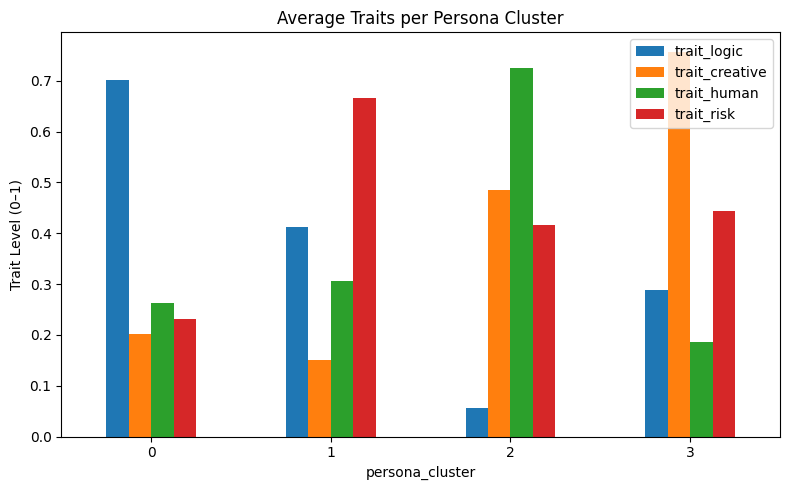

In [27]:
import matplotlib.pyplot as plt

cluster_traits.plot(kind="bar", figsize=(8,5))
plt.title("Average Traits per Persona Cluster")
plt.ylabel("Trait Level (0–1)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [28]:
career_persona = {
    "Software Developer": {
        "logic": 0.8,
        "creative": 0.4,
        "human": 0.3,
        "risk": 0.4,
    },
    "Data Scientist": {
        "logic": 0.9,
        "creative": 0.5,
        "human": 0.4,
        "risk": 0.5,
    },
    "Machine Learning Engineer": {
        "logic": 0.9,
        "creative": 0.6,
        "human": 0.3,
        "risk": 0.6,
    },
    "Financial Quant Analyst": {
        "logic": 1.0,
        "creative": 0.3,
        "human": 0.2,
        "risk": 0.7,
    },
}


In [29]:
from numpy.linalg import norm

def cosine(a, b):
    a = np.array(a, dtype=float)
    b = np.array(b, dtype=float)
    if norm(a) == 0 or norm(b) == 0:
        return 0.0
    return float(a.dot(b) / (norm(a)*norm(b)))


In [30]:
def recommend_career_for_person(row):
    user_vec = np.array([
        row["trait_logic"],
        row["trait_creative"],
        row["trait_human"],
        row["trait_risk"],
    ], dtype=float)
    
    best_career = None
    best_score = -1.0
    for career, vec_dict in career_persona.items():
        c_vec = np.array([
            vec_dict["logic"],
            vec_dict["creative"],
            vec_dict["human"],
            vec_dict["risk"],
        ], dtype=float)
        score = cosine(user_vec, c_vec)
        if score > best_score:
            best_score = score
            best_career = career
    return best_career, best_score

persona_df["persona_career"], persona_df["persona_career_score"] = zip(
    *persona_df.apply(recommend_career_for_person, axis=1)
)

persona_df[[
    "persona_name",
    "trait_logic","trait_creative","trait_human","trait_risk",
    "persona_career","persona_career_score"
]].head(10)


,persona_name,trait_logic,trait_creative,trait_human,trait_risk,persona_career,persona_career_score
0,Human-centered Leader,0.066667,0.545455,0.823529,0.333333,Data Scientist,0.654375
1,Creative Explorer,0.400000,0.000000,0.529412,0.583333,Financial Quant Analyst,0.812998
2,Creative Explorer,0.333333,0.363636,0.411765,0.666667,Machine Learning Engineer,0.883922
3,Stable Problem-Solver,0.066667,0.727273,0.176471,0.666667,Machine Learning Engineer,0.742527
4,Analytical Builder,0.666667,0.272727,0.235294,0.083333,Software Developer,0.955450
5,Creative Explorer,0.333333,0.181818,0.529412,0.500000,Data Scientist,0.856349
6,Human-centered Leader,0.066667,0.363636,0.764706,0.250000,Data Scientist,0.626641
7,Stable Problem-Solver,0.466667,0.818182,0.176471,0.166667,Machine Learning Engineer,0.859311
8,Creative Explorer,0.533333,0.000000,0.176471,0.750000,Financial Quant Analyst,0.916945
9,Stable Problem-Solver,0.533333,0.636364,0.176471,0.250000,Machine Learning Engineer,0.945367


In [31]:
persona_df["persona_career"].value_counts()

pd.crosstab(persona_df["persona_name"], persona_df["persona_career"])


persona_career,Data Scientist,Financial Quant Analyst,Machine Learning Engineer,Software Developer
persona_name,,,,
Analytical Builder,4,5,0,4
Creative Explorer,2,9,4,0
Human-centered Leader,4,0,2,0
Stable Problem-Solver,0,0,6,0


In [32]:
OUTPUT_TRAITS = DATA_DIR / "persona_traits.csv"
OUTPUT_PERSONA = DATA_DIR / "persona_cluster_names.csv"

cols_traits = [
    "trait_logic",
    "trait_creative",
    "trait_human",
    "trait_risk",
    "persona_cluster",
    "persona_name",
    "persona_career",
    "persona_career_score",
]

# Extra safety: keep only columns that actually exist
cols_traits = [c for c in cols_traits if c in persona_df.columns]

persona_df[cols_traits].to_csv(OUTPUT_TRAITS, index=False)
persona_df[["persona_cluster", "persona_name"]].drop_duplicates().to_csv(OUTPUT_PERSONA, index=False)

OUTPUT_TRAITS, OUTPUT_PERSONA


(WindowsPath('c:/Users/pavan/careerpath-ai/data/persona_traits.csv'),
 WindowsPath('c:/Users/pavan/careerpath-ai/data/persona_cluster_names.csv'))

In [33]:
# How many users per persona cluster & name
persona_df["persona_name"].value_counts()

pd.crosstab(persona_df["persona_name"], persona_df["persona_career"])


persona_career,Data Scientist,Financial Quant Analyst,Machine Learning Engineer,Software Developer
persona_name,,,,
Analytical Builder,4,5,0,4
Creative Explorer,2,9,4,0
Human-centered Leader,4,0,2,0
Stable Problem-Solver,0,0,6,0


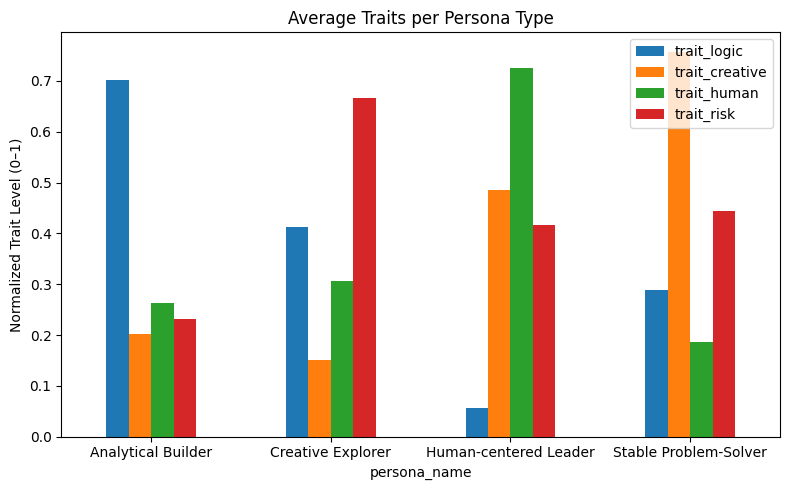

In [35]:
import matplotlib.pyplot as plt

cluster_traits = persona_df.groupby("persona_name")[
    ["trait_logic","trait_creative","trait_human","trait_risk"]
].mean()

cluster_traits.round(2)

ax = cluster_traits.plot(kind="bar", figsize=(8,5))
plt.title("Average Traits per Persona Type")
plt.ylabel("Normalized Trait Level (0–1)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()



In [36]:
persona_df[[
    "trait_logic","trait_creative","trait_human","trait_risk",
    "persona_name","persona_career","persona_career_score"
]].head(10)


,trait_logic,trait_creative,trait_human,trait_risk,persona_name,persona_career,persona_career_score
0,0.066667,0.545455,0.823529,0.333333,Human-centered Leader,Data Scientist,0.654375
1,0.400000,0.000000,0.529412,0.583333,Creative Explorer,Financial Quant Analyst,0.812998
2,0.333333,0.363636,0.411765,0.666667,Creative Explorer,Machine Learning Engineer,0.883922
3,0.066667,0.727273,0.176471,0.666667,Stable Problem-Solver,Machine Learning Engineer,0.742527
4,0.666667,0.272727,0.235294,0.083333,Analytical Builder,Software Developer,0.955450
5,0.333333,0.181818,0.529412,0.500000,Creative Explorer,Data Scientist,0.856349
6,0.066667,0.363636,0.764706,0.250000,Human-centered Leader,Data Scientist,0.626641
7,0.466667,0.818182,0.176471,0.166667,Stable Problem-Solver,Machine Learning Engineer,0.859311
8,0.533333,0.000000,0.176471,0.750000,Creative Explorer,Financial Quant Analyst,0.916945
9,0.533333,0.636364,0.176471,0.250000,Stable Problem-Solver,Machine Learning Engineer,0.945367


4.4 Personality-Aware Career Personas from Survey Responses

In addition to structured skills and resume content, we collected 40+ long-form survey responses through Google Forms. The questionnaire (Q1–Q7) focused on how users think, react to uncertainty, define success, and stay motivated. Examples include:

“When you face a new problem…”

“What does success mean to you?”

“What pushes you to keep going when things get tough?”

These answers are not directly numeric, so we designed a lightweight trait model with four dimensions:

Logic – preference for analytical thinking, structure, and problem breakdown

Creative – comfort with brainstorming, originality, and expressive work

Human – focus on people, impact, empathy, and responsibility

Risk – appetite for experimentation, uncertainty, and trying new paths

We created a mapping from each multiple-choice option (Q1–Q7) to these traits. For example:

“Break it down logically” → boosts logic

“Brainstorm wild ideas” → boosts creative

“Leading change” → boosts human + risk

“Freedom” as a core value → boosts risk, slightly reduces need for stability

For each respondent, we aggregate these contributions into a trait vector:

persona
(
𝑢
𝑠
𝑒
𝑟
)
=
[
logic
,
creative
,
human
,
risk
]
persona(user)=[logic,creative,human,risk]

We then normalize these scores between 0 and 1 and cluster users with K-Means (k = 4). This yields four emergent persona types, such as:

Analytical Builder – high logic, medium risk, low–medium creative

Creative Explorer – high creative, moderate human focus

Human-centered Leader – high human + responsibility traits

Stable Problem-Solver – balanced traits, lower risk-taking

We visualize this in the notebook using a bar chart of average traits per persona, which clearly shows how each group differs along the four axes.

Next, we define career trait profiles for the main roles in Aspira AI:

Software Developer

Data Scientist

Machine Learning Engineer

Financial Quant Analyst

Each role is described in the same 4D space. For example, a Quant Analyst has very high logic, moderate risk, and lower human / creative, while a Machine Learning Engineer combines high logic, moderate creative, and higher risk.

Finally, we compute cosine similarity between each user’s persona vector and each career profile:

score
(
𝑢
𝑠
𝑒
𝑟
,
𝑐
𝑎
𝑟
𝑒
𝑒
𝑟
)
=
cos
⁡
(
persona
(
𝑢
𝑠
𝑒
𝑟
)
,
persona
(
𝑐
𝑎
𝑟
𝑒
𝑒
𝑟
)
)
score(user,career)=cos(persona(user),persona(career))

The top-scoring career becomes the persona-based recommendation, and we store:

trait_logic, trait_creative, trait_human, trait_risk

persona_cluster, persona_name

persona_career, persona_career_score

into data/persona_traits.csv. This file is now an intermediate bridge that can be integrated into the main Aspira AI backend in future work, allowing the system to:

Use personality signals as a prior over career roles

Combine persona scores + resume embeddings + survey skill vectors for a richer hybrid recommendation.